In [1]:
from IPython.display import display, HTML, clear_output
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import pickle
import talib
import time
import json
import sys
import os

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline

In [66]:
requests.get('https://min-api.cryptocompare.com/data/top/totalvolfull?limit=10&tsym=USD')

True

In [2]:
home = os.path.expanduser('~')

## Target column is to predict 24h return after close
Shifted back one period because our goal is to predict the next 24h not the current 24h return

In [3]:
def get_data(pair, exchange='Coinbase'):
    fsym, tsym = pair.split('-')
    try:
        response = requests.get(f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={fsym}&tsym={tsym}&limit=2000&e={exchange}&tryConversion=false').json()
        data = pd.DataFrame(response['Data']['Data'])
    except:
        print('No data found for', pair, exchange)
        return []
    data.drop(['conversionType','conversionSymbol'],axis='columns',inplace=True)
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data['daily_return'] = (data['close'].pct_change()*100)
    data['target'] = (data['daily_return']).shift(-1)
    no_data = data[data['close'] == 0].index
    data.drop(no_data, axis='rows', inplace=True)
    data.reset_index(inplace=True, drop=True)
    return data

def get_best_pairs(e='Coinbase'):
    pair_info = requests.get(f'https://min-api.cryptocompare.com/data/pair/mapping/exchange?e={e}').json()['Data']
    pairs = []
    for row in pair_info:
        fsym = row['exchange_fsym']
        tsym = row['exchange_tsym']
        pairs.append(f'{fsym}-{tsym}')
    return pairs


data = get_data('BTC-USD')

In [4]:
data.head()

,time,close,high,low,open,volumefrom,volumeto,daily_return,target
0,2014-12-01,370.0,370.0,300.00,300.0,0.05656,19.530,inf,2.162162
1,2014-12-02,378.0,378.0,370.00,370.0,15.01000,5675.070,2.162162,0.000000
2,2014-12-03,378.0,378.0,377.01,378.0,0.54660,206.520,0.000000,-0.238095
3,2014-12-04,377.1,378.0,377.10,378.0,0.01000,3.771,-0.238095,0.000000
4,2014-12-05,377.1,377.1,377.10,377.1,0.00000,0.000,0.000000,0.238663


In [5]:
## days with different closes
# data['diff'] = (data['open'] - data['close'].shift(1)).abs()
# data[data['diff'] > 0]

## Feature Graveyard

volumefrom  0.043 corr  
volumefrom_lag_38 0.080 corr  
volumefrom_roll_max_158  0.047 corr  

daily return  
Lagged: 1,100 periods. 81 periods was best with 0.067 corr  
Rolling mean: 2,200 periods. 87 periods was best with 0.044 corr   

pct change in volume    
data['volume_change'] = data['volumefrom'].pct_change()*100   
Lagged: 1,100 periods. 37 periods was the best with 0.06 corr  
Rolling min: 2,200 periods. 45 was best with 0.06 corr   
Rolling mean: 2,200 periods. 4 periods was best with 0.034 corr  

distance from low from rolling window min low   
Rolling low: 5, 200 periods. 7 best with 0.065 corr  

distance from high from rolling window max high  
Rolling low: 5, 300 periods. 285 best with 0.063 corr  

distance ratio from previous high and low of x periods  
distance_from_high_low_7 best with 0.087 corr 

ema_173_close_diff_close  0.041 corr  

slowd_7_1  0.076 corr  
slowd_7_1_lag_41 0.089 corr  

stoch_turn_down_88	0.013722	35.0  
stoch_turn_up_66	0.255452	163.0  

CDLTAKURI_0_0	0.082076	51.0  
CDLCLOSINGMARUBOZU_0_0	0.122812	114.0  

adx_10_5_10_down	0.024288	28.0	-1.085460  
adx_12_70_20_up	0.041131	16.0	-1.001554  

## Features

In [6]:
def add_roll_and_lag(data, feature, roll_range, lag_range):
    for roll in roll_range:
        data[f"{feature}_roll_mean_{roll}"] = data[feature].rolling(roll,roll).mean()
        data[f"{feature}_roll_std_{roll}"] = data[feature].rolling(roll,roll).std()
        data[f"{feature}_roll_min_{roll}"] = data[feature].rolling(roll,roll).min()
        data[f"{feature}_roll_max_{roll}"] = data[feature].rolling(roll,roll).max()

    for lag in lag_range:
        data[f"{feature}_lag_{lag}"] = data[feature].shift(lag)
        
    data[f"{feature}_pct_change"] = data[feature].pct_change() * 100
    return data
        
#data = add_roll_and_lag(data,'volumefrom', range(2,100,5), range(1,100,5))

In [7]:
def dist_from_high_low(data, win_range, plot=False):
    for win in win_range:
        for col in ['high','low']:
            if col == 'high':
                data[f"extreme_{col}_{win}"] = data[col].rolling(win, win).max()
                data[f"dist_from_{col}_window_{win}"] = (1 - (data[col] / data[col].rolling(win, win).max()))*100
            elif col == 'low':
                data[f"extreme_{col}_{win}"] = data[col].rolling(win, win).min()
                data[f"dist_from_{col}_window_{win}"] = (1 - (data[col].rolling(win, win).min() / data[col]))*100 
                
        dist_high = data[f"dist_from_high_window_{win}"]
        dist_low = data[f"dist_from_low_window_{win}"]
        data[f"distance_from_high_low_{win}"] = dist_low / (dist_high + dist_low)
    
    ## plotting results
    if plot:
        for plot_col in ['low','high']:
            fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
            plt.subplots_adjust(wspace=0, hspace=0)
            data[0:200].plot(x='time',y=f"extreme_{plot_col}_10", ax=ax[0])
            data[0:200].plot(x='time', y=plot_col, ax=ax[0])
            data[0:200].plot(x='time', y=f"dist_from_{plot_col}_window_10", color='k', ax=ax[1])

        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
        plt.subplots_adjust(wspace=0, hspace=0)
        data[0:200].plot(x='time',y=f"extreme_low_10", ax=ax[0])
        data[0:200].plot(x='time',y=f"extreme_high_10", ax=ax[0])
        data[0:200].plot(x='time',y='low', ax=ax[0])
        data[0:200].plot(x='time',y='high', ax=ax[0])
        data[0:200].plot(x='time', y="distance_from_high_low_10", color='k', ax=ax[1])
    return data
    
#data = dist_from_high_low(data, range(5,100,5))

In [8]:
def ema(data, roll_range):
    points = ['high','low','close']
    for price_point in points:
        for price_point_diff in points:
            for roll in roll_range:
                ema = talib.EMA(data[price_point], timeperiod=roll)
                data[f"ema_{roll}_{price_point}_diff_{price_point_diff}"] = ((data[price_point_diff] / ema) -1) * 100
    return data
        
#data = ema(data, range(2,100,5))

In [9]:
def stoch(data, period_range, speed_range, plot=False):
    for period in range(2,15,2):
        for speed in range(1,15,2):
            data[f'slowk_{period}_{speed}'], data[f'slowd_{period}_{speed}'] = talib.STOCH(data['high'], data['low'], data['close'], period, speed, 0, speed, 0)

    ## plot data
    if plot:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
        plt.subplots_adjust(wspace=0, hspace=0)
        data[:200].plot(x='time', y='close', ax=ax[0])
        data[:200].plot(x='time', y=f'slowk_5_3', ax=ax[1])
        data[:200].plot(x='time', y=f'slowd_5_3', ax=ax[1])
    return data
    
    
def stoch_turn(data, thresh_range, plot=False):
    period = 5
    speed = 3
    data[f'slowk_{period}_{speed}'], data[f'slowd_{period}_{speed}'] = talib.STOCH(data['high'], data['low'], data['close'], period, speed, 0, speed, 0)
    
    for thresh in thresh_range:
        turn_up = (data[f'slowk_{period}_{speed}'].shift(1) < data[f'slowd_{period}_{speed}'].shift(1)) & \
                  (data[f'slowk_{period}_{speed}'] > data[f'slowd_{period}_{speed}']) & \
                  (data[f'slowd_{period}_{speed}'] <= thresh)
        data[f'stoch_turn_up_{thresh}'] = 0
        data.loc[turn_up,f'stoch_turn_up_{thresh}'] = 1
        
    for thresh in thresh_range:
        turn_down = (data[f'slowk_{period}_{speed}'].shift(1) > data[f'slowd_{period}_{speed}'].shift(1)) & \
                    (data[f'slowk_{period}_{speed}'] < data[f'slowd_{period}_{speed}']) & \
                    (data[f'slowd_{period}_{speed}'] >= thresh)
        data[f'stoch_turn_down_{thresh}'] = 0
        data.loc[turn_down,f'stoch_turn_down_{thresh}'] = 1
    
    ## plot data
    if plot:
        fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,10))
        plt.subplots_adjust(wspace=0, hspace=0)
        data[:200].plot(x='time', y='close', ax=ax[0])
        data[:200].plot(x='time', y=f'slowk_5_3', ax=ax[1])
        data[:200].plot(x='time', y=f'slowd_5_3', ax=ax[1])  
        data[:200].plot(x='time', y=f'stoch_turn_up_20', ax=ax[2])
        data[:200].plot(x='time', y=f'stoch_turn_down_80', ax=ax[3])
    return data
    
#data = stoch(data, range(2,15,2), range(1,15,2))
#data = stoch_turn(data, range(1,100,5))

In [10]:
def candlestick_patters(data, meth_filter=None):
    if meth_filter:
        candle_meth = {meth:getattr(talib,meth) for meth in dir(talib) if 'CDL' in meth and meth in meth_filter}
    else:
        candle_meth = {meth:getattr(talib,meth) for meth in dir(talib) if 'CDL' in meth}
    for name, meth in candle_meth.items():
        data[f"{name}_0_0"] = meth(data['open'], data['high'], data['low'], data['close'])
        sample = data[f"{name}_0_0"] > 0
        data.loc[sample,f"{name}_0_0"] = 1
    return data
        
#data = candlestick_patters(data)

In [11]:
def adx(data, period_range, upper_range, padding_range, plot=False):
    for period in period_range:
        for upper in upper_range:
            for padding in padding_range:
                name = f'adx_{period}_{upper}_{padding}'
                data[name] = talib.ADX(data['high'], data['low'], data['close'], period)
                roll = data['close'].rolling(period).mean()
                down = (data[name] > upper) & (data[name] < upper+padding) & (data['close'] <= roll)
                up = (data[name] > upper) & (data[name] < upper+padding) & (data['close'] > roll)
                data.loc[down,f"{name}_down"] = 1
                data.loc[up,f"{name}_up"] = 1
        
    ## plot data
    if plot:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
        plt.subplots_adjust(wspace=0, hspace=0)
        data[:200].plot(x='time', y='close', ax=ax[0])
        data[:200].plot(x='time', y=f'adx_10_60_20', ax=ax[1])
    return data
    
#data = adx(data, range(4,15,2), range(5,80,10), range(5,30,5))

In [12]:
def day_of_week(data):
    day = data['time'].dt.dayofweek
    days = pd.get_dummies(day)
    days.columns = ['mon','tue','wed','thu','fri','sat','sun']
    data = pd.concat([days,data], axis='columns', sort=False)
    return data

#data = day_of_week(data)

In [13]:
def rsi(data, period_range, plot=False):
    for period in range(4,50,5):
        data[f'rsi_{period}'] = talib.RSI(data['close'], period)

    ## plot data
    if plot:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
        plt.subplots_adjust(wspace=0, hspace=0)
        data[:200].plot(x='time', y='close', ax=ax[0])
        data[:200].plot(x='time', y=f'rsi_10', ax=ax[1])
    return data
    
#data = rsi(data, range(4,50,5))

In [14]:
# import plotly.graph_objects as go

# import pandas as pd
# from datetime import datetime

# fig = go.Figure(data=[go.Candlestick(x=data['time'],
#                 open=data['open'],
#                 high=data['high'],
#                 low=data['low'],
#                 close=data['close'])])

# # fig.add_trace(go.Scatter(x=data['time'], y=data['doji']))

# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

In [15]:
#data.corr()['target'].abs().sort_values(ascending=False).head(30)

In [16]:
from scipy.stats import ks_2samp

def binary_var(data, feature_name, range1=None, range2=None, range3=None, range4=None):
    results = {}
    target_mean = data['target'].mean()
    if range4:
        for feat1 in range1:
            for feat2 in range2:
                for feat3 in range3:
                    for feat4 in range4:
                        binary_feature = f'{feature_name}_{feat1}_{feat2}_{feat3}_{feat4}'
                        feature = data[data[binary_feature] == 1]
                        non_feature = data[data[binary_feature] == 0]

                        if len(feature) == 0:
                            continue
                        t, p = ks_2samp(feature['target'], data['target'])
                        results[binary_feature] = {'p_value':p, '#_instances':len(feature), 'target_mean_diff':feature['target'].mean() - target_mean}
    
    elif range3:
        for feat1 in range1:
            for feat2 in range2:
                for feat3 in range3:
                    binary_feature = f'{feature_name}_{feat1}_{feat2}_{feat3}'
                    feature = data[data[binary_feature] == 1]
                    non_feature = data[data[binary_feature] == 0]

                    if len(feature) == 0:
                        continue
                    t, p = ks_2samp(feature['target'], data['target'])
                    results[binary_feature] = {'p_value':p, '#_instances':len(feature), 'target_mean_diff':feature['target'].mean() - target_mean}
    
    elif range2:
        for feat1 in range1:
            for feat2 in range2:
                binary_feature = f'{feature_name}_{feat1}_{feat2}'
                feature = data[data[binary_feature] == 1]
                non_feature = data[data[binary_feature] == 0]

                if len(feature) == 0:
                    continue
                t, p = ks_2samp(feature['target'], data['target'])
                results[binary_feature] = {'p_value':p, '#_instances':len(feature), 'target_mean_diff':feature['target'].mean() - target_mean}
    
    elif range1:
        for feat1 in range1:
            binary_feature = f'{feature_name}_{feat1}'
            feature = data[data[binary_feature] == 1]
            non_feature = data[data[binary_feature] == 0]

            if len(feature) == 0:
                continue
            t, p = ks_2samp(feature['target'], data['target'])
            results[binary_feature] = {'p_value':p, '#_instances':len(feature), 'target_mean_diff':feature['target'].mean() - target_mean}
            
    else:
        binary_feature = f'{feature_name}'
        feature = data[data[binary_feature] == 1]
        non_feature = data[data[binary_feature] == 0]
        t, p = ks_2samp(feature['target'], data['target'])
        results[f"{feature_name}"] = {'p_value':p, '#_instances':len(feature), 'target_mean_diff':feature['target'].mean() - target_mean}
    
    data.fillna(0,inplace=True)
    return pd.DataFrame(results).transpose()


def plot_binary_var(data, feature_name):
    feature = data[data[feature_name] == 1]
    non_feature = data[data[feature_name] == 0]
    ax = feature['target'].plot.kde(figsize=(12,8), legend=True)
    non_feature['target'].plot.kde(ax=ax, legend=True)
    data['target'].plot.kde(ax=ax, legend=True)
    ax.legend(["feature", "no_feature", "all_data"])

    dp = 2
    print('all_data',round(data['target'].mean(),dp),'|',round(data['target'].std(),dp))
    print('feature',round(feature['target'].mean(),dp),'|',round(feature['target'].std(),dp))
    print('non_feature',round(non_feature['target'].mean(),dp),'|',round(non_feature['target'].std(),dp))

    
def candlestick_test():
    results = {}
    for name, meth in candle_meth.items():
        results1 = binary_var(data, name, [0], [0])
        if results1:
            results[list(results1.keys())[0]] = list(results1.values())[0]
    return pd.DataFrame(results).transpose().sort_values('p_value')


#results = binary_var(data, 'adx', range1=range(4,13), range2=range(5,80,5), range3=range(5,30,5), range4=['up','down'])

In [17]:
# sample = pd.DataFrame(results).transpose()
# sample = sample[sample['#_instances']>10]
# sample = sample[sample['p_value'] <= 0.05]
# sample.sort_values(['target_mean_diff'], ascending=False).head(30)

In [18]:
# feature1 = data[data['adx_12_65_5_up'] == 1]
# feature2 = data[data['adx_12_70_5_down'] == 1]
# ax = feature1['target'].plot.kde(legend=True, title='Feature Engineering for Bitcoin', color='g')
# feature2['target'].plot.kde(ax=ax, legend=True, color='r')
# data['target'].plot.kde(ax=ax, legend=True, style='b--')
# ax.legend(["Buy feature", "Sell feature", "Bitcoin returns"])
# ax.set_xlim(-30,30)
# ax.set_xlabel('Bitcoin daily returns %')

In [19]:
# plot_binary_var(data, 'adx_12_65_5_up')
# plot_binary_var(data, 'adx_12_70_5_down')

In [20]:
# data.plot.scatter(x='target',y='adx_4_75_5_down')

## Pipeline

In [21]:
def feature_pipeline(data):
    data = add_roll_and_lag(data,'volumefrom', range(2,100,5), range(1,100,5))
    data = add_roll_and_lag(data,'volumefrom_pct_change', range(2,100,5), range(1,100,5))
    data = add_roll_and_lag(data,'daily_return', range(2,100,5), range(1,100,5))
    data = dist_from_high_low(data, range(5,100,5))
    data = ema(data, range(2,200,10))
    data = stoch(data, range(2,15,2), range(1,15,2))
    data = stoch_turn(data, range(1,100,5))
    data = candlestick_patters(data)
    data = adx(data, range(4,15,2), range(5,80,10), range(5,30,5))
    data = day_of_week(data)
    data = adx(data, range(4,15,2), range(5,80,10), range(5,30,5))
    data = rsi(data, range(4,50,5))
    
    data.fillna(0, inplace=True)
    return data

def best_features(data, features):
    data = data[features+['target']]
    return data

# time_col = data['time'].copy()
# data.drop(columns=['time'], inplace=True)
# data = feature_pipeline(data)

## Create master dataset

In [22]:
def master_dataset(data, get_existing_data, exchange, max_pairs):
    file_name = f'xgboost_data_{exchange}_{max_pairs}_{str(datetime.now().date())}.csv'
    exists = os.path.exists(file_name)
    if get_existing_data and exists:
        data = pd.read_csv(file_name)
    else:
        pairs = get_best_pairs(e=exchange)
        all_pairs = []
        for pair in pairs[0: max_pairs]:
            print(pair)
            response = get_data(pair, exchange)
            if len(response) == 0: 
                continue
            response = feature_pipeline(response)
            all_pairs.append(response)
        data = pd.concat(all_pairs)
        data.reset_index(inplace=True, drop=True)
        data.to_csv(file_name, index=False)
    return data

#### vars ####
get_existing_data = True
exchange = 'Coinbase'
max_pairs = 10
##############

data = master_dataset(data, get_existing_data, exchange, max_pairs)    
time_col = data['time'].copy()
data.drop(columns=['time'], inplace=True)

## Best features

In [23]:
# best = ['volumefrom_lag_11', 'volumefrom_pct_change_roll_min_2',
#        'ema_82_high_diff_low', 'distance_from_high_low_5',
#        'daily_return_lag_96', 'high', 'slowk_4_1', 'adx_9',
#        'dist_from_high_window_15', 'ema_152_low_diff_close']
# data = best_features(data, best)

## Data normalization

In [24]:
def normalize(data):
    #data['target'] = pd.cut(data['target'],bins=[-30,-10,-5,-3,-1,1,3,5,10,30])
    # data['target'] = pd.cut(data['target'],bins=[-30,0,30])
    # data['target'] = data['target'].astype(str)
    # data['target'].value_counts(normalize=True)*100
    
    # max_filter = 5
    # large = data['target'] > max_filter
    # small = data['target'] < -max_filter
    # data.loc[large,'target'] = max_filter
    # data.loc[small,'target'] = -max_filter
    
    pos = data['target'] > 0
    neg = data['target'] <= 0
    # pos = (data['target'] > -0.5) & (data['target'] < 1)
    # neg = (data['target'] <= -0.5) | (data['target'] >= 1)
    data.loc[pos,'target'] = 1
    data.loc[neg,'target'] = 0
    return data

## Select model

In [25]:
problem = 'classification' #'regression', 'classification'

In [26]:
# k-fold cross validation evaluation of xgboost model
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import (train_test_split,  
                                     KFold, 
                                     cross_val_score,
                                     cross_val_predict,
                                    )

real_target = data['target'].copy()
if problem == 'classification':
    data = normalize(data)
    binary_perc = data['target'].value_counts(normalize=True).values
    binary_perc

# load data
target = 'target'
features = [col for col in data.columns.to_list() if col != target]

# split data
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=67)

if problem == 'regression':
    model = xgb.XGBRegressor()
elif problem == 'classification':
    model = xgb.XGBClassifier(objective='binary:logistic')

## Tune hyperparams

In [27]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# params = {
#     'learning_rate'         : [ 0.01, 0.02, 0.03, 0.04, 0.05],
#     'max_depth'             : [ 1, 2, 3, 4, 5 ],
#     'min_child_weight'      : [ 5, 7, 9, 12, 15, 20, 25 ],
#     'gamma'                 : [ 0.0, 0.01, 0.02, 0.03, 0.05, 0.1 ],
#     'colsample_bytree'      : [ 0.6, 0.7, 0.8, 0.9 ],
#     'early_stopping_rounds' : [ 5, 10, 30],
# }
# if problem == 'classification':
#     params['objective'] = ['binary:logistic']
# random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=20, n_jobs=-1, cv=5, verbose=3)
# random_search.fit(X_train, y_train)

# print(random_search.best_params_)
# print(random_search.best_estimator_)

In [28]:
# # good
# model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.7, early_stopping_rounds=30,
#              gamma=0.02, importance_type='gain', learning_rate=0.05,
#              max_delta_step=0, max_depth=5, min_child_weight=9, missing=None,
#              n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
#              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#              seed=None, silent=None, subsample=1, verbosity=1)

## Train model (save/pickle)

In [29]:
## Straight
model.fit(X_train, y_train)

# ## CV model
# kfold = KFold(n_splits=3, random_state=7)
# cross_val_predict(model, X_train, y_train, cv=kfold, method='predict_proba')
# model.fit(X_train, y_train)

# # Save model to file
pickle.dump(model, open('crypto_xbg.pkl', "wb"))

## Load model

In [53]:
#model = pickle.load(open('crypto_xbg.pkl', "rb"))

## Out of sample

In [43]:
# ### vars ####
# exchange = 'HitBTC'
# # pair = get_best_pairs(exchange)[52]
# pair = 'IOST-USD'
# ############

# print(exchange, pair)
# data = get_data(pair,exchange)
# time_col = data['time'].copy()
# data = feature_pipeline(data)
# data.drop(columns=['time'], inplace=True)
# real_target = data['target'].copy()
# if problem == 'classification':
#     data = normalize(data)
# # load data
# target = 'target'
# features = [col for col in data.columns.to_list() if col != target]
# # split data
# X_test = data[features]
# y_test = data[target]

## Test model

In [44]:
prediction_on = 'test' # 'test','train'

In [45]:
pred_dataset_x = X_train if prediction_on == 'train' else X_test
pred_dataset_y = y_train if prediction_on == 'train' else y_test

y_predict_proba = model.predict_proba(pred_dataset_x) if problem == 'classification' else None
predictions = model.predict(pred_dataset_x)

/home/jhuckle/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Accuracy 0.6102502979737783 Class percentage 0.502 Improvement (>1?) 1.215


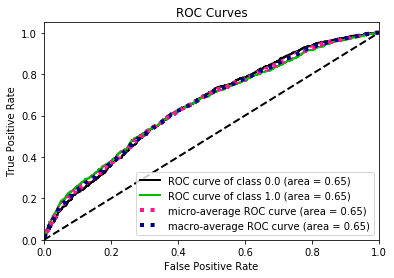

In [46]:
import scikitplot as skplt
if problem == 'classification':
    skplt.metrics.plot_roc_curve(pred_dataset_y, y_predict_proba)
    acc = metrics.accuracy_score(pred_dataset_y, predictions)
    print("Accuracy", acc, "Class percentage", round(binary_perc[0],3), "Improvement (>1?)", round(acc/binary_perc[0],3))

## Backtest long,short,both

long
1225.7443727297282


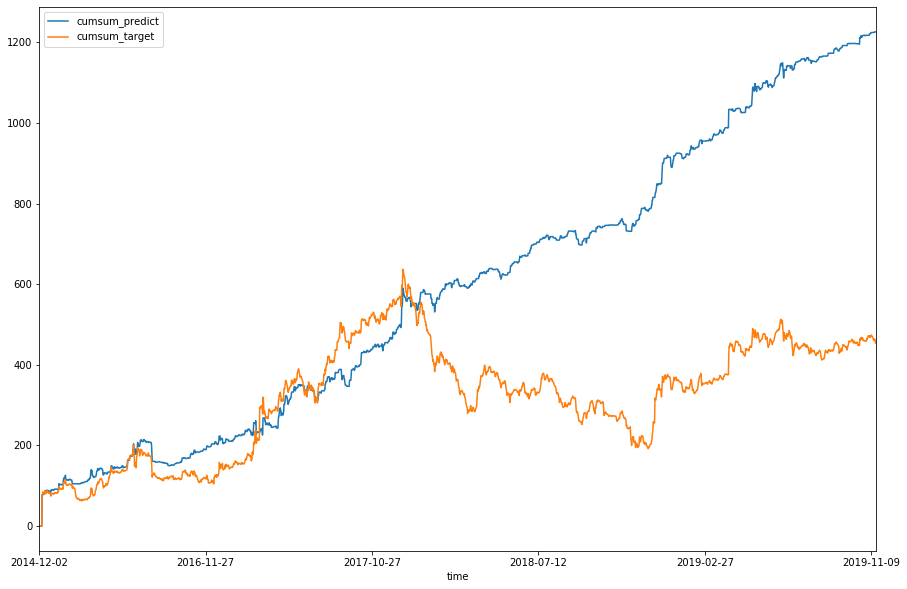

short
772.2881591573663


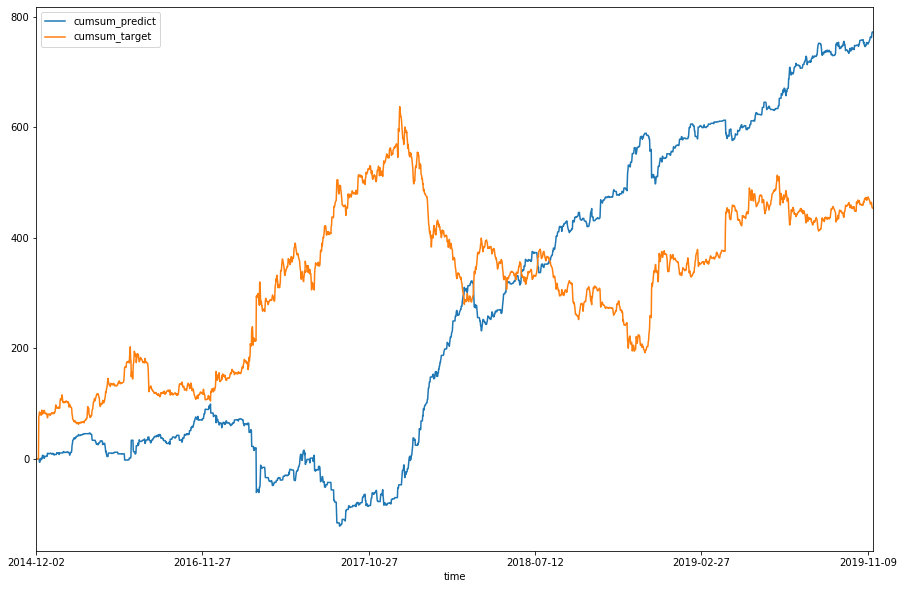

both
1998.0325318870946


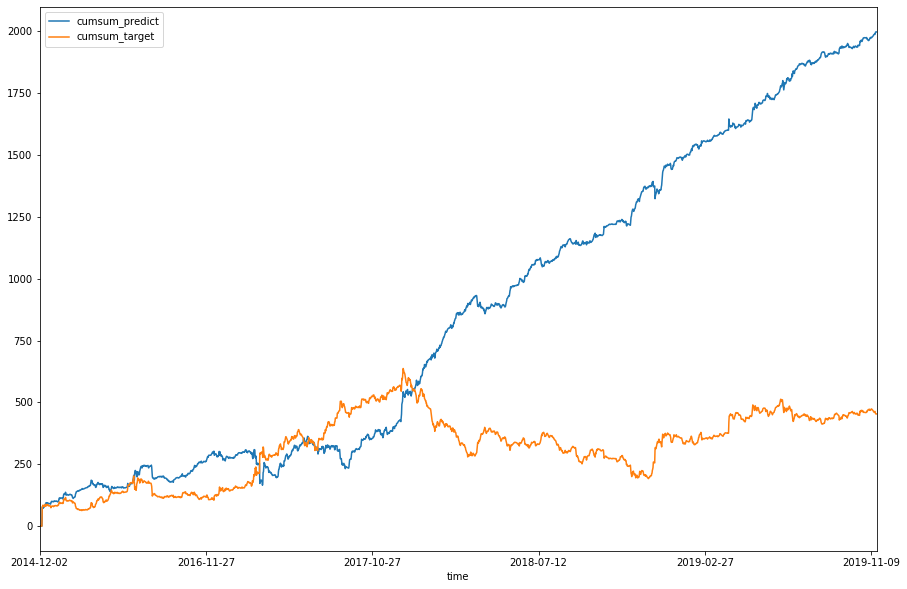

In [47]:
all_results = {}
for position in ['long','short','both']:
    print(position)
    
    x_target = real_target[pred_dataset_x.index].values
    x_time = time_col[pred_dataset_x.index].values
    results = pd.DataFrame([x_time, x_target, predictions]).transpose()
    results.columns = ['time', 'target', 'predict']
    results.sort_values('time', inplace=True)

    if problem == 'classification':
        up = results[results['predict'] == 1].index
        down = results[results['predict'] == 0].index
        if position == 'short':
            results.loc[down, 'predict'] = -1
            results.loc[up, 'predict'] = 0
        elif position == 'long':
            None
        elif position == 'both':
            results.loc[down, 'predict'] = -1
        results['final'] = results['target'] * results['predict']

    elif problem == 'regression':
        up = results[results['predict'] >= 0].index
        down = results[results['predict'] <= 0].index
        if position == 'short':
            results.loc[down, 'final'] = -results['target']
        elif position == 'long':
            results.loc[up, 'final'] = results['target']
        elif position == 'both':
            results.loc[up, 'final'] = results['target']
            results.loc[down, 'final'] = -results['target']

    results['final'] = results['final'].fillna(0)
    results['cumsum_predict'] = results['final'].cumsum()
    results['cumsum_target'] = results['target'].cumsum()
    all_results[position] = results
    ax = results.plot(x='time', y='cumsum_predict', figsize=(15,10))
    results.plot(x='time', y='cumsum_target', ax=ax)
    print(results['final'].sum())
    plt.show()

In [48]:
all_results['both']

,time,target,predict,final,cumsum_predict,cumsum_target
974,2014-12-02,0,-1,-0.000000,-0.000000,0
1063,2014-12-04,0,-1,-0.000000,-0.000000,0
298,2014-12-06,0,-1,-0.000000,-0.000000,0
1870,2014-12-12,0,-1,-0.000000,-0.000000,0
277,2015-01-05,0,-1,-0.000000,-0.000000,0
744,2015-01-06,0,-1,-0.000000,-0.000000,0
2496,2015-01-08,0,-1,-0.000000,-0.000000,0
1015,2015-01-11,0,-1,-0.000000,-0.000000,0
508,2015-01-14,76.5917,1,76.591667,76.591667,76.5917
2376,2015-01-23,2.12766,1,2.127660,78.719326,78.7193


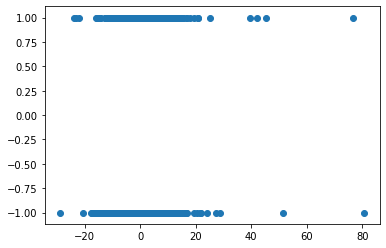

In [49]:
plt.scatter(x=results['target'], y=results['predict'])

In [50]:
if problem == 'regression':
    final = pd.DataFrame([predictions, y_test]).transpose()
    final.columns = ['predictions','y_test']
    final['mean'] = 0.27154374825584504
    final['zero'] = 0
    mse_random_guess = metrics.mean_absolute_error(final['y_test'],final['mean'])
    rmse_random_guess = mse_random_guess ** 0.5
    mse_predict = metrics.mean_absolute_error(final['y_test'],final['predictions'])
    rmse_predict = mse_predict ** 0.5
    print('error random guess',round(rmse_random_guess,4))
    print('error prediction  ', round(rmse_predict,4))

## Predict Today

In [51]:
# today = data[features].tail(1)
# model.predict_proba(today)

## Feature Importances

In [52]:
pd.options.display.max_rows = 10000
importances = dict(zip(features , model.feature_importances_))
importances = pd.Series(importances)                                                                                                                                     
importances = importances.sort_values(ascending=False)
#importances.index[0:10]
importances

slowd_2_13                            0.019887
slowd_12_11                           0.013614
slowd_4_13                            0.009425
distance_from_high_low_35             0.009173
distance_from_high_low_80             0.009143
daily_return_lag_71                   0.009094
daily_return_roll_std_47              0.008954
slowd_5_3                             0.008727
daily_return                          0.008377
volumeto                              0.007929
volumefrom_pct_change_roll_min_82     0.007608
rsi_19                                0.007582
daily_return_roll_std_32              0.007197
ema_2_high_diff_close                 0.007191
volumefrom_pct_change_roll_mean_72    0.006999
adx_4_35_25_up                        0.006734
slowk_14_3                            0.006731
slowd_2_7                             0.006717
fri                                   0.006421
daily_return_roll_mean_22             0.006409
daily_return_roll_std_2               0.006361
extreme_low_5